Majorana fermions suffer from a sign problem and are difficult to compute naively on the lattice. We will use some previous work to try to implement a Majorana fermion in $(1+1)d$, with the future goal of trying to simulate 2d adjoint QCD on the lattice (and specifically a variant of 2d adjoint QCD with 4-fermion deformations as given in https://arxiv.org/abs/1908.09858). 

### The Pfaffian

The sign problem in the Majorana fermion enters through the fermion Pfaffian. Expanding the action as a fermionic part and a bosonic part yields,
\begin{equation}
    S[U, \psi] = S_g[U] + \int d^2x\, d^2 y \psi^T(x)\mathcal D(x, y) \psi(y)
\end{equation}
where $\mathcal D(x, y)$ is the Dirac operator (this will be discussed later). Integrating this quadratic Majorana fermion action results in a Pfaffian of the Dirac operator
\begin{equation}
    \mathcal Z = \int DU \, D\psi \, e^{-S_g[U] - \int \psi^T\mathcal D \psi} = \int DU\, \mathrm{Pf}(\mathcal D)\, e^{-S_g[U]}.
\end{equation}

### Sign problems

Incorporating the Pfaffian into an effective action will require the use of the identity
\begin{equation}
    |\mathrm{Pf}[\mathcal D]| = |\det\mathcal D|^{1/2} = (\det [\mathcal D^\dagger \mathcal D])^{1/4} \propto \int D\Phi D\Phi^\dagger \exp \left[ -\Phi^\dagger (\mathcal D^\dagger \mathcal D)^{-1/4} \Phi \right].
\end{equation}
where here $\Phi$ and $\Phi^\dagger$ are bosonic pseudofermion fields. The assumption here that $|\mathrm{Pf}[\mathcal D]| = \mathrm{Pf}[\mathcal D]$ is not in general correct, and the Pfaffian can have an arbitrary phase 
\begin{equation}
    \mathrm{Pf}[\mathcal D[U]] = e^{i\alpha[U]} |\mathrm{Pf}[\mathcal D[U]]|
\end{equation}
where $\alpha[U]$ is the phase associated with the configuration $U$. One can deal with the possibility of non-zero phase by reweighting, which absorbs the phase into the denominator. The idea is to define the \textbf{phase-quenched path integral} as
\begin{align}
    \langle \mathcal O \rangle_{pq} \equiv \frac{1}{\mathcal Z_{pq}}\int DU\, |\mathrm{Pf}[\mathcal D[U]]| e^{-S_g[U]} \mathcal O && 
    \mathcal Z_{pq} \equiv \int DU\, |\mathrm{Pf}[\mathcal D[U]]| e^{-S_g[U]},
\end{align}
i.e. we use the norm of the Pfaffian instead of the complex Pfaffian. With this phase quenching, one can then evaluate a correlator as:
\begin{equation}
    \langle\mathcal O \rangle = \frac{\langle \mathcal O e^{i\alpha} \rangle_{pq}}{\langle e^{i\alpha} \rangle_{pq}}
\end{equation}
The key here is to measure $\langle e^{i\alpha}\rangle_{pq}$ and make sure it never gets close to zero; if it does, the theory will have a sign problem!

### RHMC

A lot of key details can be found in David Schaich and Tom DeGrand's article discussing their software package, `SUSY LATTICE`. 

To generate gauge field configurations, it looks like most approaches use rational Hamiltonian Monte Carlo (RHMC) because of the $(\cdot)^{-1/4}$ in the pseudofermion action.

In [1]:
import os
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
import h5py
import seaborn as sns

from importlib import reload

import rhmc

# MACBOOK PATHS
# lqcd_path = '/Users/theoares/lqcd/utilities'
# dropbox_path = 'TODO'

# DESKTOP PATHS
lqcd_path = '/home/patrickoare/lqcd'
dropbox_path = '/mnt/c/Users/Patrick/Dropbox (MIT)/research/2d_adjoint_qcd'

sys.path.append(f'{lqcd_path}/utilities')
import plottools as pt
from formattools import *
default_style = styles['notebook']
pt.set_font()

## Plot plaquettes and other observables

In [2]:
Nc = 2
l, t = 8, 8
gens = rhmc.get_generators(Nc)
Lat = rhmc.Lattice(l, t)
beta = 2.0
kappa = 0.125
bcs = rhmc.DEFAULT_BCS

In [5]:
fnames = [
    f'{dropbox_path}/meas/tests/wilson_Nc2_8_8_b2p0_k0p125_cold/cfgs.h5',
    f'{dropbox_path}/meas/tests/wilson_Nc2_8_8_b2p0_k0p125_hot/cfgs.h5',
    # f'{dropbox_path}/meas/tests/wilson_Nc2_8_8_b2p0_k0p125_hot/cfgs2.h5',
    # f'{dropbox_path}/meas/tests/wilson_Nc2_8_8_b2p0_k0p125_hot/cfgs3.h5',
]
cfg_names = [
    'cold', 
    'hot1', 
    # 'hot2', 
    # 'hot3'
]
cfgs = []
for fname in fnames:
    f = h5py.File(fname, 'r')
    cfgs.append(f['U'][()])
    f.close()
cfgs = np.array(cfgs)

In [6]:
# compute observables on each config for each stream
observables = {
    'plaquette'  : [], 
    'polyakov'   : [],
    'top_charge' : [],
    # 'pfaffian'   : []
}
obs_fns = {
    'plaquette' : lambda U : np.sum(rhmc.plaquette(U)),
    'polyakov' : rhmc.polyakov_loop,
    'top_charge' : rhmc.topological_charge,
    # 'pfaffian' : rhmc.get_pf_observable(kappa, gens, lat = Lat, bcs = bcs)
}
obs_labels = {
    'plaquette'  : r'$P$',
    'polyakov'   : r'$P_{\mathrm{Polyakov}}$',
    'top_charge' : r'$Q$',
    # 'pfaffian'   : r'Pf'
}
obs_keys = observables.keys()

for obs_name in obs_keys:
    obs_fn = obs_fns[obs_name]
    for U_list in cfgs:
        obs_list = []
        for U in U_list:
            obs_list.append(obs_fn(U))
        observables[obs_name].append(np.array(obs_list))
    observables[obs_name] = np.array(observables[obs_name])

In [7]:
reload(pt)

<module 'plottools' from '/home/patrickoare/lqcd/utilities/plottools.py'>

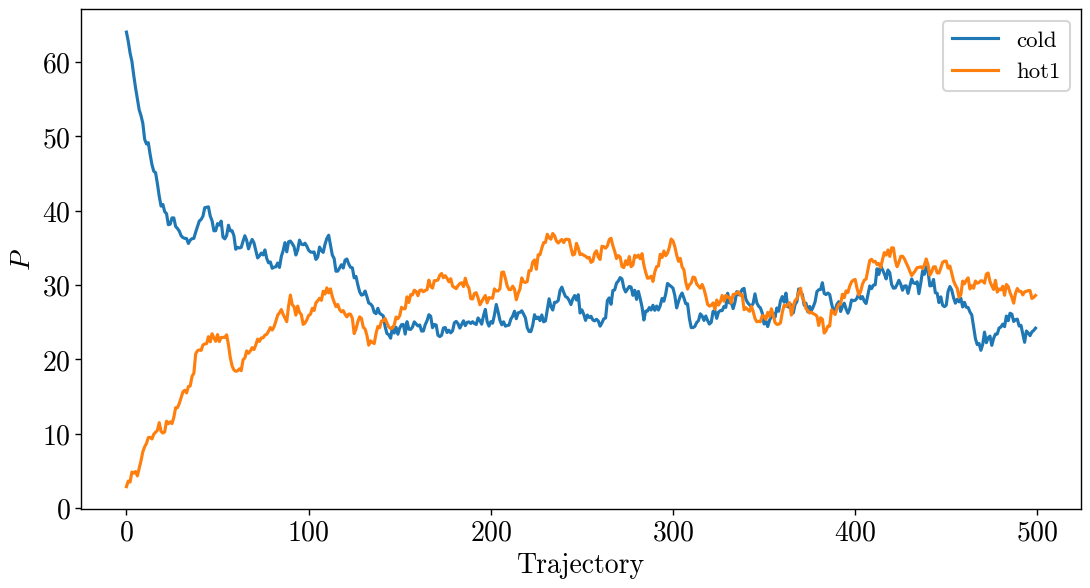

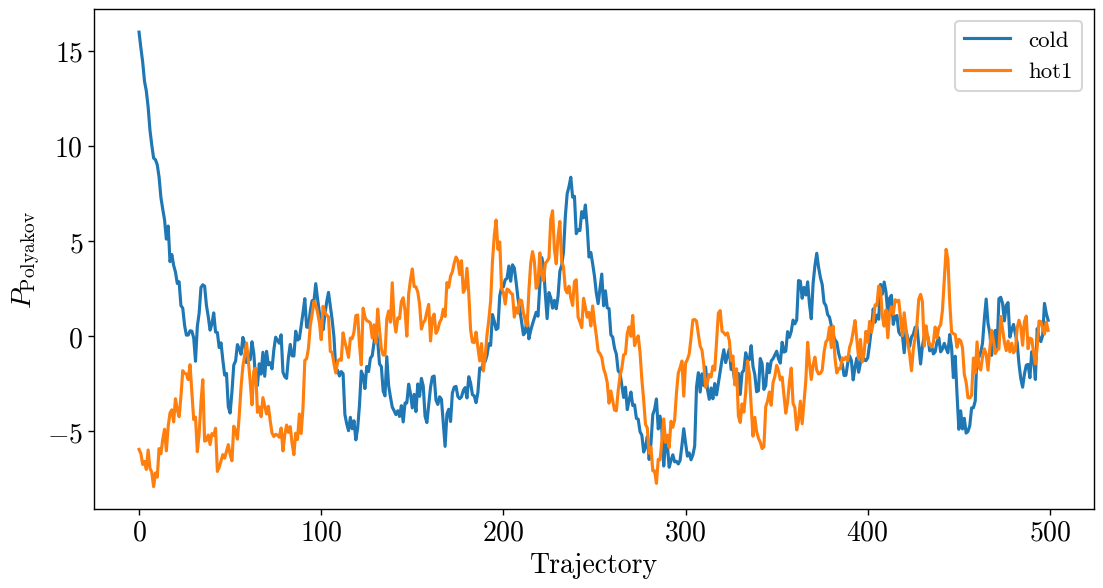

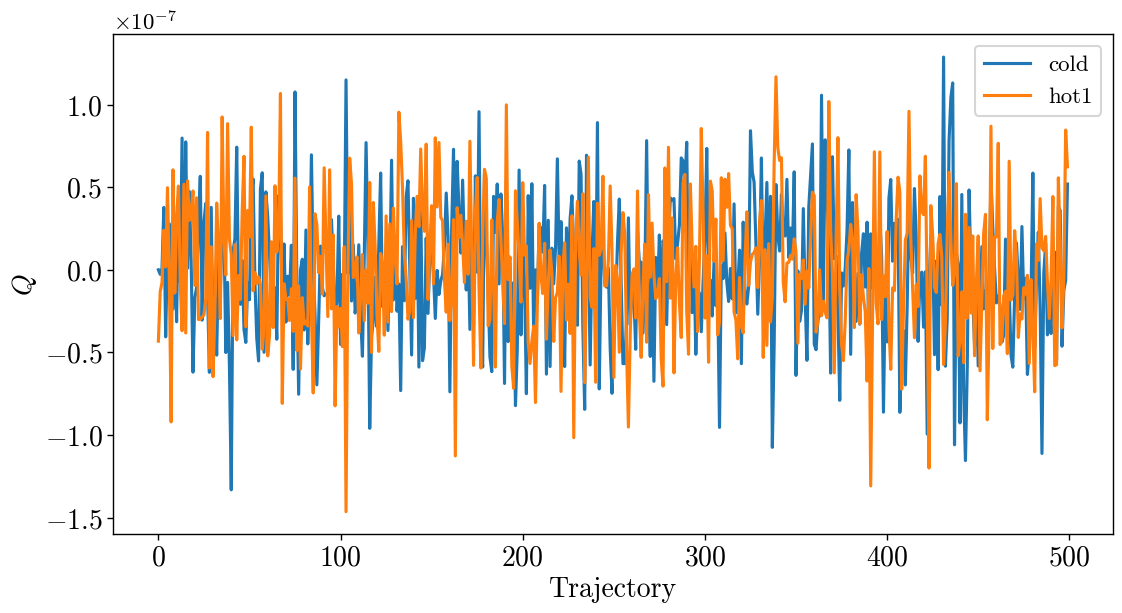

In [8]:
for key in observables:
    fig, axes = pt.add_subplots()
    ax = axes[0]
    for idx, obs in enumerate(observables[key]):
        pt.plot_1d_data(np.arange(len(obs)), np.real(obs), ax = ax, ax_label = ['Trajectory', obs_labels[key]], col = pt.pal[idx], 
                        fn_label = cfg_names[idx], legend = True, tight_layout = False)